# Predicting the presence of heart disease in a patient based on their medical and demographic information

## Introduction:
Heart disease, also known as cardiovascular disease, refers to a range of conditions that affect the heart and blood vessels. This can include coronary artery disease, heart failure, and arrhythmias. Heart disease is a global leading cause of death, with risk factors including high blood pressure, high cholesterol, smoking, and diabetes. 
The question that we plan to answer is: Can we predict the presence of heart disease in a patient based on their medical and demographic information? To answer this question, we will be using the Heart Disease dataset from the UCI Machine Learning Repository. This dataset contains information on 303 patients who underwent diagnostic testing for heart disease. The dataset includes 14 attributes, such as age, sex, cholesterol levels, and electrocardiograph readings. 


## Methods and Results:

We will be comparing the num values (Integers that state whether a patient has heart disease), to age, resting blood pressure (trestbps), cholesterol (chol), max heart rate received (thalach). This will help us create a program that can predict whether or not a patient has heart disease. 

Age can be a good indicator of heart disease over an entire population as when age increases fragility usually increases (Rodgers et al. 2019).  An increase in fragility means a decrease in overall strength and health and the risk of heart disease increases as patient’s weaken.

Resting heart rate can be a predictor of heart disease as higher resting heart rate was found to be higher in people with heart disease (Aune et al. 2017).  A lower resting heart rate is a good indicator of overall heart health and thus a higher resting heart rate indicates poorer heart health. Although a high resting heart rate is not a direct indication of heart disease it can be used in conjunction with other predictors to help identify heart disease. 

It is well documented that high cholesterol is a great indicator of heart disease (Mayo Clinic n.d). This works well as an indicator as patients with higher cholesterol levels have a greater chance of having heart disease. High cholesterol leads to fatty deposits forming in veins and arteries, which is one of the many symptoms of heart disease.

Although maximum heart rate achieved is not a direct indicator of heart disease, it is a good indicator of heart health. As previously discussed, the poorer the heart health, the increased risk of heart disease (Aune et al. 2017). A maximum heart rate achieved is varied over a population, but the average can be useful as an indicator of heart health.  A higher maximum heart rate is a good indicator of heart health as a “higher heart rate is a good thing that leads to greater fitness”  (John Hopkins Medicine n.d).

These variables should allow us to predict whether a patient has heart disease with relative certainty. The selected columns have a wide range of values compared to the others, which have very little variation.  This should give us an accurate prediction for any patient’s data.

We will visualize the results using a scatter plot to first compare the selected variables to the num values. We can also use a scatter plot + a line plot to show the possible correlations between our selected columns and the num values.

In [21]:
library(tidyverse)
library(tidymodels)
library(repr)
library(rvest)
library(stringr)
options(repr.matrix.max.rows = 6)
set.seed(4321)

### Demonstrate that the dataset can be read from the web into R 

In [6]:
url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
download.file(url, destfile = "processed-cleveland.data")

### Clean and wrangle your data into a tidy format

In [7]:
heart_data <- read_csv("processed-cleveland.data",)
colnames(heart_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
heart_data <- heart_data |>
    mutate(num = if_else(num==0, 0, 1)) |>  
    mutate(num = as_factor(num))
    

heart_data[heart_data == "?"] <- NA

New names:
* `1.0` -> `1.0...2`
* `1.0` -> `1.0...3`
* `1.0` -> `1.0...6`
* `0.0` -> `0.0...9`
* `0.0` -> `0.0...12`
Rows: 302 Columns: 14
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


Here we read the csv file, and set the column names to their according identifies as according to the original source of the dataset. We also mutate the num column to be 0 (representing the absence of heart disease), and 1 (the presence of heart disease). We believe that our model should classify the existence of heart disease, and for further classification, meeting a health professional would be the best route for the patient from there.

In [8]:
heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,1
57,0,2,130,236,0,2,174,0,0.0,2,1.0,3.0,1
38,1,3,138,175,0,0,173,0,0.0,1,NA,3.0,0


### Exploratory Data Analysis
Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 

In [28]:
heart_summary <- heart_data |>
    map_df(~sum(!is.na(.)), na.rm=TRUE)
heart_summary

mean_variables <- heart_data |>
    group_by(num) |>
    summarize(mean_age=mean(age, na.rm=TRUE),
             mean_chol=mean(chol, na.rm=TRUE),
             mean_thalach=mean(thalach, na.rm=TRUE),
             mean_oldpeak=mean(oldpeak, na.rm=TRUE))
mean_variables

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
302,302,302,302,302,302,302,302,302,302,302,298,300,302


num,mean_age,mean_chol,mean_thalach,mean_oldpeak
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,52.52147,242.6994,158.4294,0.5760736
1,56.62590,251.4748,139.2590,1.5741007


**Table 1: Count of every column in the heart disease dataset**

In our first summary table, we compute the number of non-NA values in each column (predictor), and find that they are all equal except for ca, and thal. Thus we will disclude these when selecting predictors.

**Table 2: Mean values of our chosen predictors in the heart disease dataset**
The second table depicts the large difference in the means when comparing num=0, to num=4, for our 4 chosen predictors. This indicates that our chosen predictors should be able to identify heart disease existence with reasonable confidence.

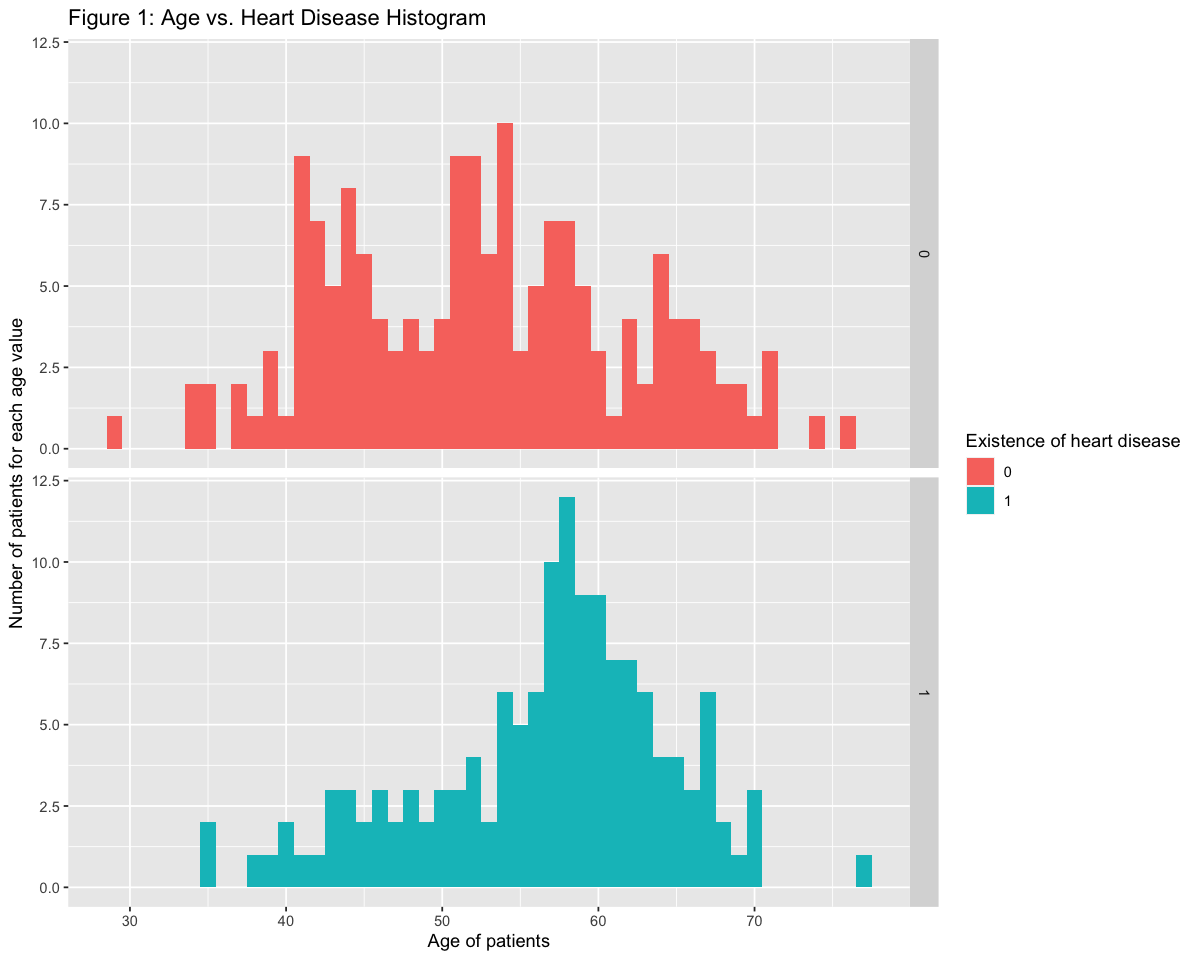

In [26]:
options(repr.plot.width = 10, repr.plot.height = 8) 

age_hist <- ggplot(heart_data, aes(x = age, fill = num)) +
    geom_histogram(position = "identity", binwidth=1) +
    facet_grid(rows = vars(num)) +
    labs(title = "Figure 1: Age vs. Heart Disease Histogram", x="Age of patients", y="Number of patients for each age value", fill="Existence of heart disease")


age_hist

The above histogram depicts the distribution of age for each num value, depicting a clear increase in the median as the num value changes from 0 to 1. We can see that the median for num=0, is closer to 50, whereas the median for num=1 is much closer to 60. As the change is quite significant, we can safely use age as a predictor.

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


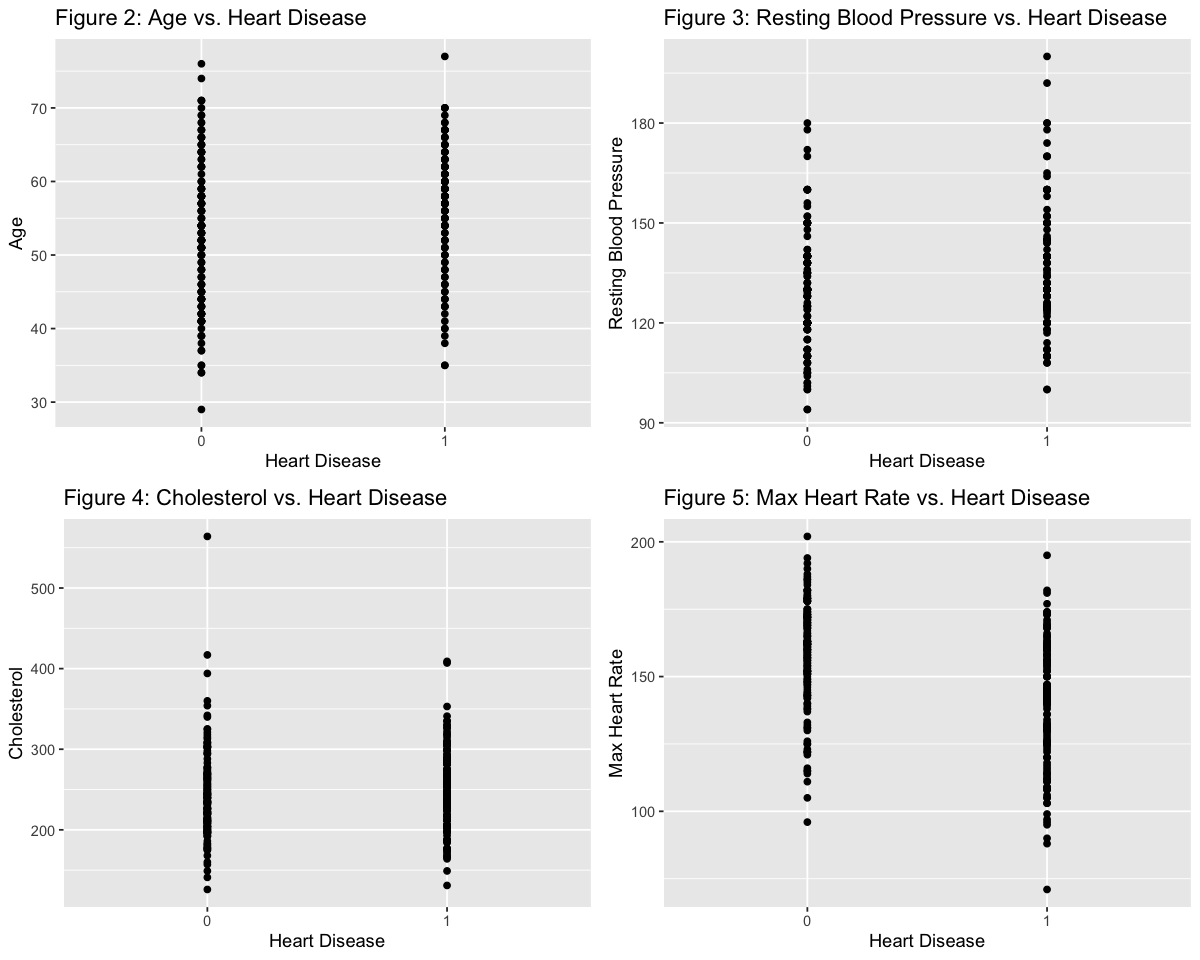

In [17]:
p_age <- ggplot(heart_data, aes(x = num, y = age)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "blue") +
  labs(title = "Figure 2: Age vs. Heart Disease",
       x = "Heart Disease",
       y = "Age")

p_trestbps <- ggplot(heart_data, aes(x = num, y = trestbps)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "blue") +
  labs(title = "Figure 3: Resting Blood Pressure vs. Heart Disease",
       x = "Heart Disease",
       y = "Resting Blood Pressure")

p_chol <- ggplot(heart_data, aes(x = num, y = chol)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "blue") +
  labs(title = "Figure 4: Cholesterol vs. Heart Disease",
       x = "Heart Disease",
       y = "Cholesterol")

p_thalach <- ggplot(heart_data, aes(x = num, y = thalach)) +
  geom_point() +
  geom_smooth(method = "lm", se = FALSE, color = "blue") +
  labs(title = "Figure 5: Max Heart Rate vs. Heart Disease",
       x = "Heart Disease",
       y = "Max Heart Rate")

# Display the plots
gridExtra::grid.arrange(p_age, p_trestbps, p_chol, p_thalach, nrow = 2)

The graphs indicate that individuals closer to the age of 60 are at higher risk of heart disease. Generally, there appears to be little to no presence of heart disease risk in individuals aged 30 to 40. While this indicates seniors are the age group that are the most susceptible to heart disease, there is no strong relationship present between age and risk of heart disease. 

For blood pressure, the risk of heart disease is most common in individuals with a resting blood pressure of roughly 100 to 170. Outside of this range, those with levels ranging from 90 to 120 are more susceptible compared to levels surpassing 170.   

Cholesterol levels of roughly 150 to 375 have the highest risks of heart disease. It is also indicated that levels surpassing this value have little to no presence of heart disease. This suggests that there is a threshold effect for cholesterol levels and risk of heart disease. 

It is shown that as maximum heart rate decreases, risk of heart disease tends to fall. The risks of heart disease are higher for those with a maximum heart rate of approximately 100 to 175. Generally there is no strong relationship between maximum heart rate and risk of heart disease, meaning that maximum heart rate is not a reliable predictor. 

### Data Analysis

In [37]:
selected_data <- heart_data |>
select(age, trestbps, chol, thalach, num)

set.seed(1234)
heart_split <- initial_split(selected_data, prop = 0.75, strata = num)  
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6325188,4,0.03435704,Preprocessor1_Model01
1,roc_auc,binary,0.6277399,4,0.03565809,Preprocessor1_Model01
3,accuracy,binary,0.6499060,4,0.03998372,Preprocessor1_Model02
...,...,...,...,...,...,...
69,roc_auc,binary,0.7420647,4,0.03615081,Preprocessor1_Model35
71,accuracy,binary,0.6680764,4,0.02256564,Preprocessor1_Model36
71,roc_auc,binary,0.7419303,4,0.03526469,Preprocessor1_Model36


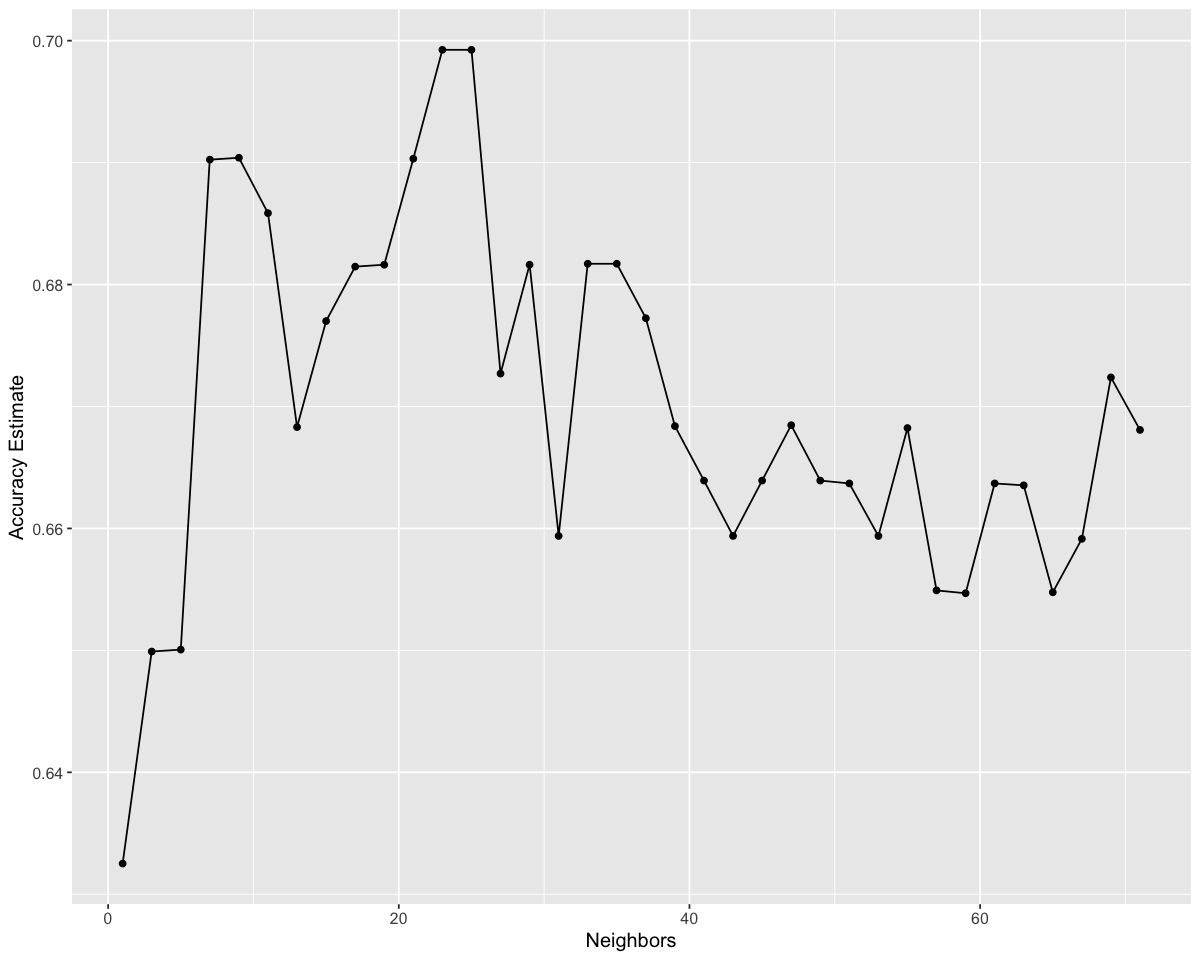

In [42]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

recipe_knn <- recipe(num ~ ., data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

# Cross-validation, 4-fold
heart_vfold <- vfold_cv(heart_train, v = 4, strata = num)

heart_workflow <- workflow() |>
  add_model(knn_spec) |>
  add_recipe(recipe_knn)

# Set K = 1, 3, 5, ..., 71, and see which K is the best
gridvals <- tibble(neighbors = seq(1, 71, by = 2))
heart_results <- heart_workflow |>
  tune_grid(resamples = heart_vfold, grid = gridvals) |>
  collect_metrics()

heart_results

accuracies <- heart_results |>
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k


In [43]:
best_k <- heart_results |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean)) |>
  slice(1) |>
  pull(neighbors)
best_k

# Train the k-NN model with the best k
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_best_fit <- workflow() |>
  add_model(knn_best_spec) |>
  add_recipe(recipe_knn) |>
  fit(data = heart_train)

[1] 23

In [44]:
heart_test_predictions <- predict(knn_best_fit, heart_test) |>
  bind_cols(heart_test)

heart_test_predictions |>
  metrics(truth = num, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6578947


### Discussion

### Summary of Results
To arrive at our accuracy value, we performed cross-validation to find the best k value and ran knn classification utilizing it. This resulted in a k value of 23, which is also visualized on the accuracy-vs-k graph, and produced an accuracy of 0.66. While this accuracy is better than random guessing, it is not high enough to be used to provide an accurate diagnosis when a patient is feeling said symptoms. Thus, to answer our predictive question, we think that our chosen predictors do not provide a valuable enough diagnosis of heart disease in patients. If we had more time, we would perform further predictor variable selection.

### Expected findings and results
We expect to find that as all the selected variables increase, the respective num value should increase. Since heart disease is the narrowing of the blood vessels, there should be a positive relationship between blood pressure and heart disease. Cholesterol and maximum heart rate achieved are also great indicators of heart health. Low values in these variables correlate to good heart health, thus heart disease and these variables should also have a positive relationship. Finally, age and heart disease should have a positive relationship, as a person gets older, their overall health tends to decline. Therefore, the older the patient the greater the presence of heart disease, when looked over the entire 303 patients.

### Impact of findings and Future Questions
These findings could help determine if a patient has heart disease without doing any rigorous testing. The variables we selected are easily testable at any doctor’s office. A reliable way to predict heart disease could help save those who are affected each year. This data analysis could lead to further questions about if/how other variables correlate to heart disease. Or how you can reduce: cholesterol, resting bps, and maximum heart rate, if they in fact are positively correlated to heart disease.

References 


> Aune, D., Sen, A., ó'Hartaigh, B., Janszky, I., Romundstad, P. R., Tonstad, S., & Vatten, L. J. (2017). Resting heart rate and the risk of cardiovascular disease, total cancer, and all-cause mortality – A systematic review and dose–response meta-analysis of prospective studies. Nutrition, Metabolism and Cardiovascular Diseases, 27(6), 504–517. https://doi.org/10.1016/j.numecd.2017.04.004

> Janosi, A., Steinbrunn, W., & Detrano, R. (n.d.). UCI Machine Learning Repository: Heart disease data set. Retrieved March 20, 2023, from https://archive.ics.uci.edu/ml/datasets/Heart+Disease

> Mayo Foundation for Medical Education and Research. (2023, January 11). High cholesterol. Mayo Clinic. Retrieved April 5, 2023, from https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/symptoms-causes/syc-20350800#:~:text=Your%20body%20needs%20cholesterol%20to,to%20flow%20through%20your%20arteries

> Rodgers, J. L., Jones, J., Bolleddu, S. I., Vanthenapalli, S., Rodgers, L. E., Shah, K., Karia, K., & Panguluri, S. K. (2019). Cardiovascular risks associated with gender and aging. Journal of Cardiovascular Development and Disease, 6(2), 19. https://doi.org/10.3390/jcdd6020019

> Understanding your target heart rate. Understanding Your Target Heart Rate | Johns Hopkins Medicine. (2021, November 3). Retrieved April 5, 2023, from https://www.hopkinsmedicine.org/health/wellness-and-prevention/understanding-your-target-heart-rate 
